![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest gap-filling
</b>
</span>

---
**Notebook version**: `2` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using random forest to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [32]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.63.1


</br>

# **Docstring** for `RandomForestTS`

In [3]:
help(RandomForestTS)

Help on class RandomForestTS in module diive.pkgs.gapfilling.randomforest_ts:

class RandomForestTS(builtins.object)
 |  RandomForestTS(input_df: pandas.core.frame.DataFrame, target_col: str, verbose: int = 0, perm_n_repeats: int = 10, test_size: float = 0.25, features_lag: list = None, include_timestamp_as_features: bool = False, add_continuous_record_number: bool = False, sanitize_timestamp: bool = False, **kwargs)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_df: pandas.core.frame.DataFrame, target_col: str, verbose: int = 0, perm_n_repeats: int = 10, test_size: float = 0.25, features_lag: list = None, include_timestamp_as_features: bool = False, add_continuous_record_number: bool = False, sanitize_timestamp: bool = False, **kwargs)
 |      Gap-fill timeseries with predictions from random forest model
 |      
 |      Args:
 |          input_df:
 |              Contains timeseries of 1 target column and 1+ feature columns.
 |      
 |          target_col:
 |          

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.076 seconds). Detected time resolution of <30 * Minutes> / 30T 


## Make subset

In [5]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [6]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671446
std,6.085451,7.548653,3.710180,247.531312
min,-38.653390,-23.096000,0.000000,0.000000
25%,-7.840419,-0.800000,0.661000,0.000000
50%,-3.827018,4.600000,1.990568,2.596048
75%,0.606166,10.067000,4.375000,225.677750
max,25.290227,28.713000,32.118000,1197.799920


In [7]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
SD,6.085451
VAR,37.032717
SD/MEAN,-1.587431


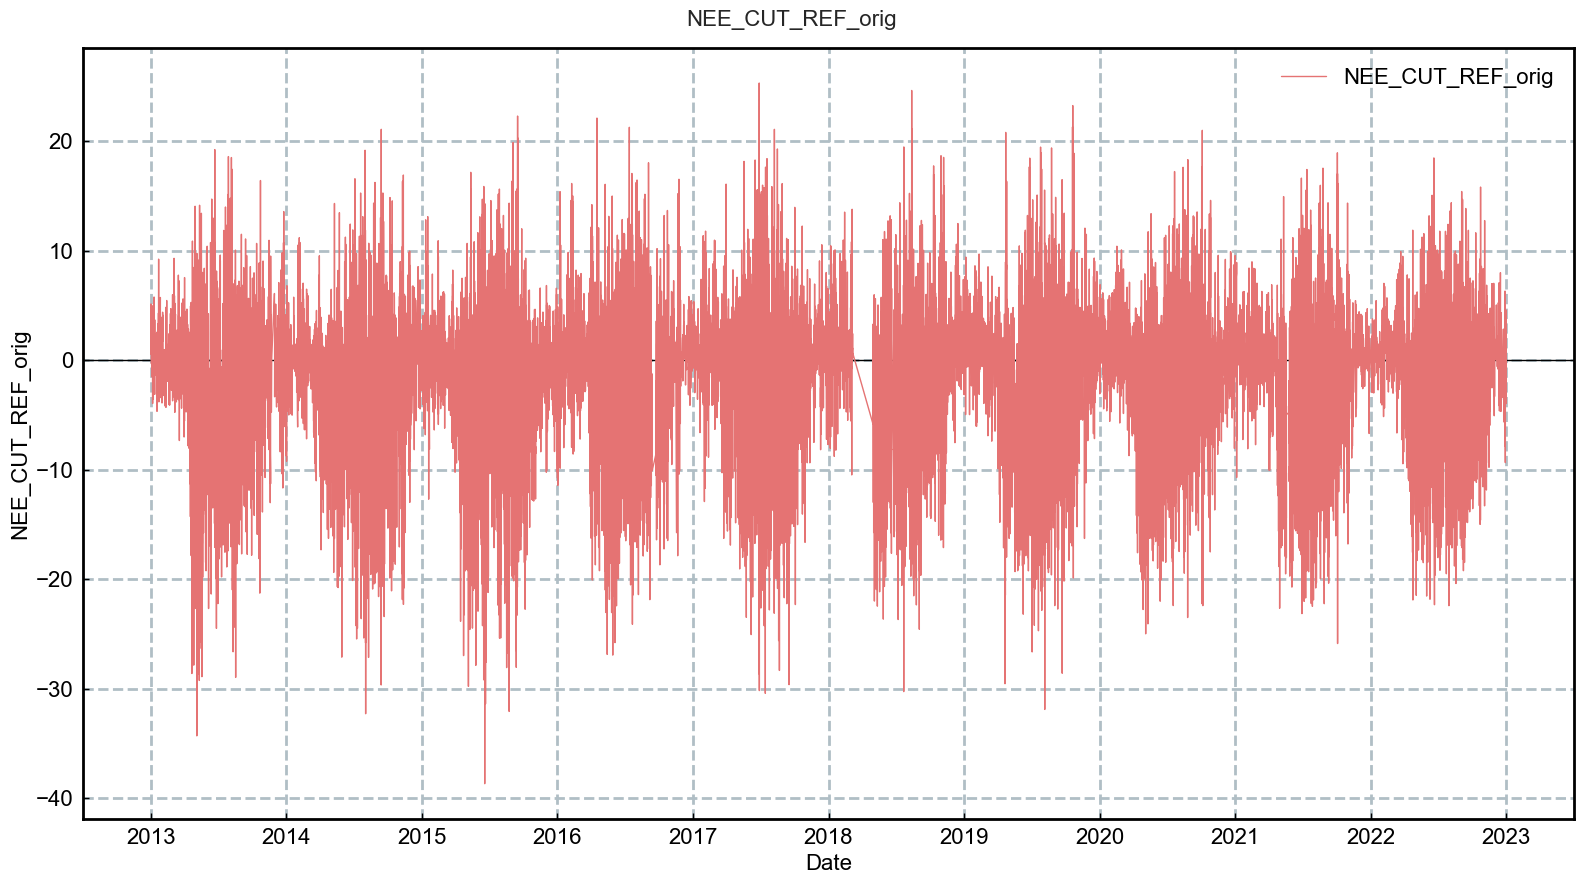

In [8]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize random forest

In [9]:
# Random forest
rfts = RandomForestTS(
    input_df=df,
    target_col=TARGET_COL,
    verbose=1,    
    features_lag=[-1, -1],    
    include_timestamp_as_features=True,    
    add_continuous_record_number=True,
    sanitize_timestamp=True,
    n_estimators=99,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    perm_n_repeats=33,
    n_jobs=-1
)


Creating lagged variants ...
Created lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f'] (lags between -1 and -1 with stepsize 1)
No lagged variants for: ['NEE_CUT_REF_orig']

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
Sorting timestamp TIMESTAMP_MIDDLE ascending ... Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ... 

</br>

## Feature reduction

In [10]:
rfts.reduce_features()

Feature reduction ...


In [11]:
rfts.report_feature_reduction()


FEATURE REDUCTION

- the random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances
- target variable: NEE_CUT_REF_orig
- features before reduction: ['Rg_f', '.DOY', '.Tair_f-1', 'Tair_f', '.HOUR', '.Rg_f-1', '.VPD_f-1', 'VPD_f', '.RECORDNUMBER', '.WEEK', '.YEARDOY', '.YEARMONTH', '.YEARWEEK', '.SEASON', '.MONTH', '.YEAR', '.RANDOM']
- permutation importance was calculated from 33 permutations
- These results are from feature reduction. Note that feature importances for the final model are calculated during gap-filling.


PERMUTATION IMPORTANCE (FULL RESULTS):

               PERM_IMPORTANCE   PERM_SD
Rg_f                  1.144854  0.015330
.DOY                  0.155979  0.004819
.Tair_f-1             0.104334  0.002278
Tair_f                0.091687  0.002930
.HOUR                 0.069084  0.002786
.Rg_f-1               0.060504  0.001889
.VPD_f-1              0.053963  0.001570
VPD_f                 0.023511  0.001049


</br>

## Train model

Building random forest model based on data between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...


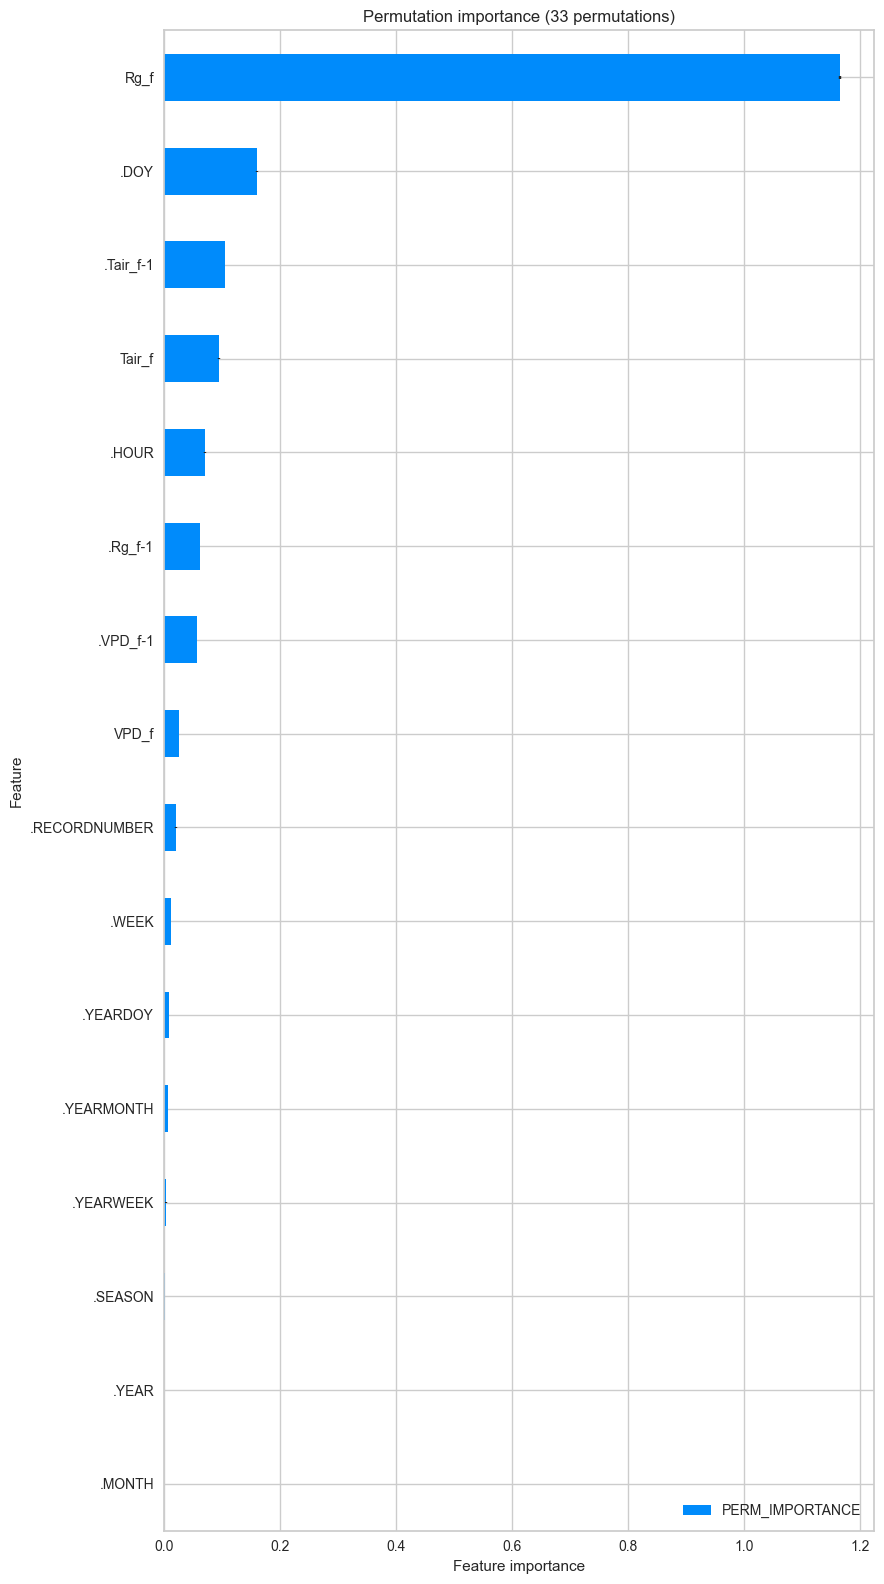

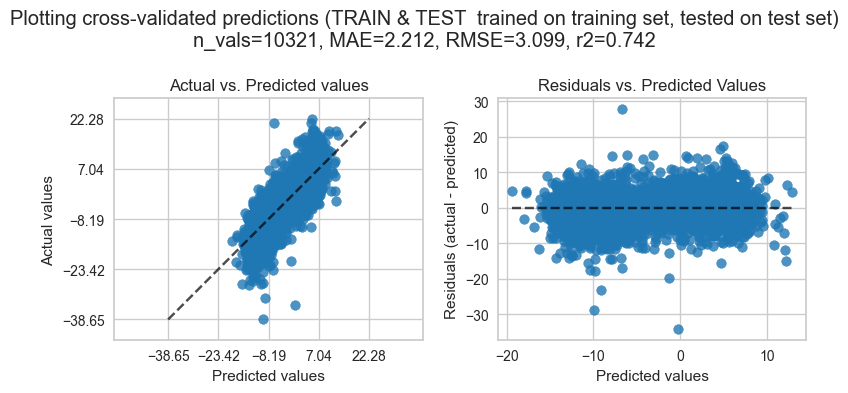

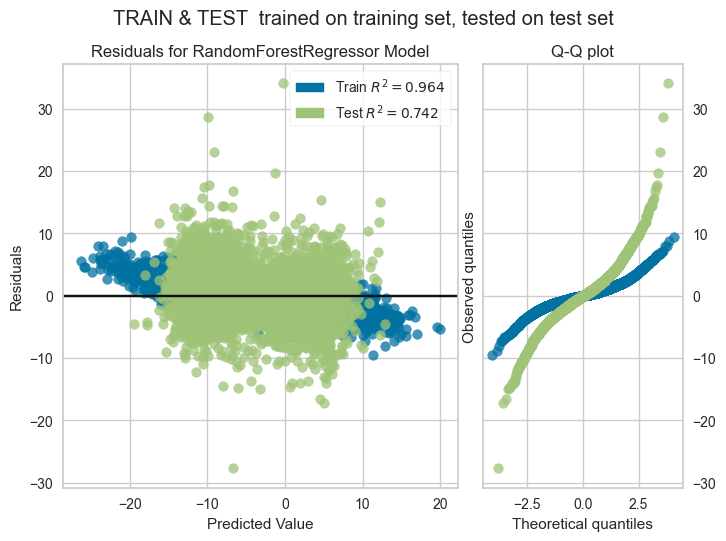

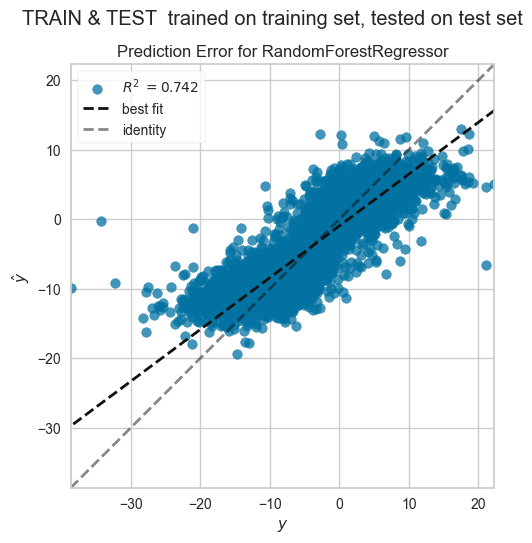

In [12]:
rfts.trainmodel(showplot_scores=True, showplot_importance=True)

In [13]:
rfts.report_traintest()


MODEL TRAINING & TESTING RESULTS

- the model was trained and tested based on data between 2013-01-01T01:45:00.000000000 and 2022-12-31T22:15:00.000000000.
- in total, 41284 observed target values were available for training and testing
- the dataset was split into training and test datasets
  > the training dataset comprised 30963 target values (75.0%)
  > the test dataset comprised 10321 target values (25.0%)

## FEATURE IMPORTANCES
- feature importances were calculated for test data (10321 target values).
- permutation importances were calculated from 33 repeats.
               PERM_IMPORTANCE   PERM_SD
Rg_f                  1.165858  0.015552
.DOY                  0.159883  0.004824
.Tair_f-1             0.104726  0.002509
Tair_f                0.095338  0.002972
.HOUR                 0.071144  0.002633
.Rg_f-1               0.061706  0.001785
.VPD_f-1              0.056958  0.001721
VPD_f                 0.026315  0.001135
.RECORDNUMBER         0.020721  0.000810
.WEEK           

</br>

## Apply model to fill gaps

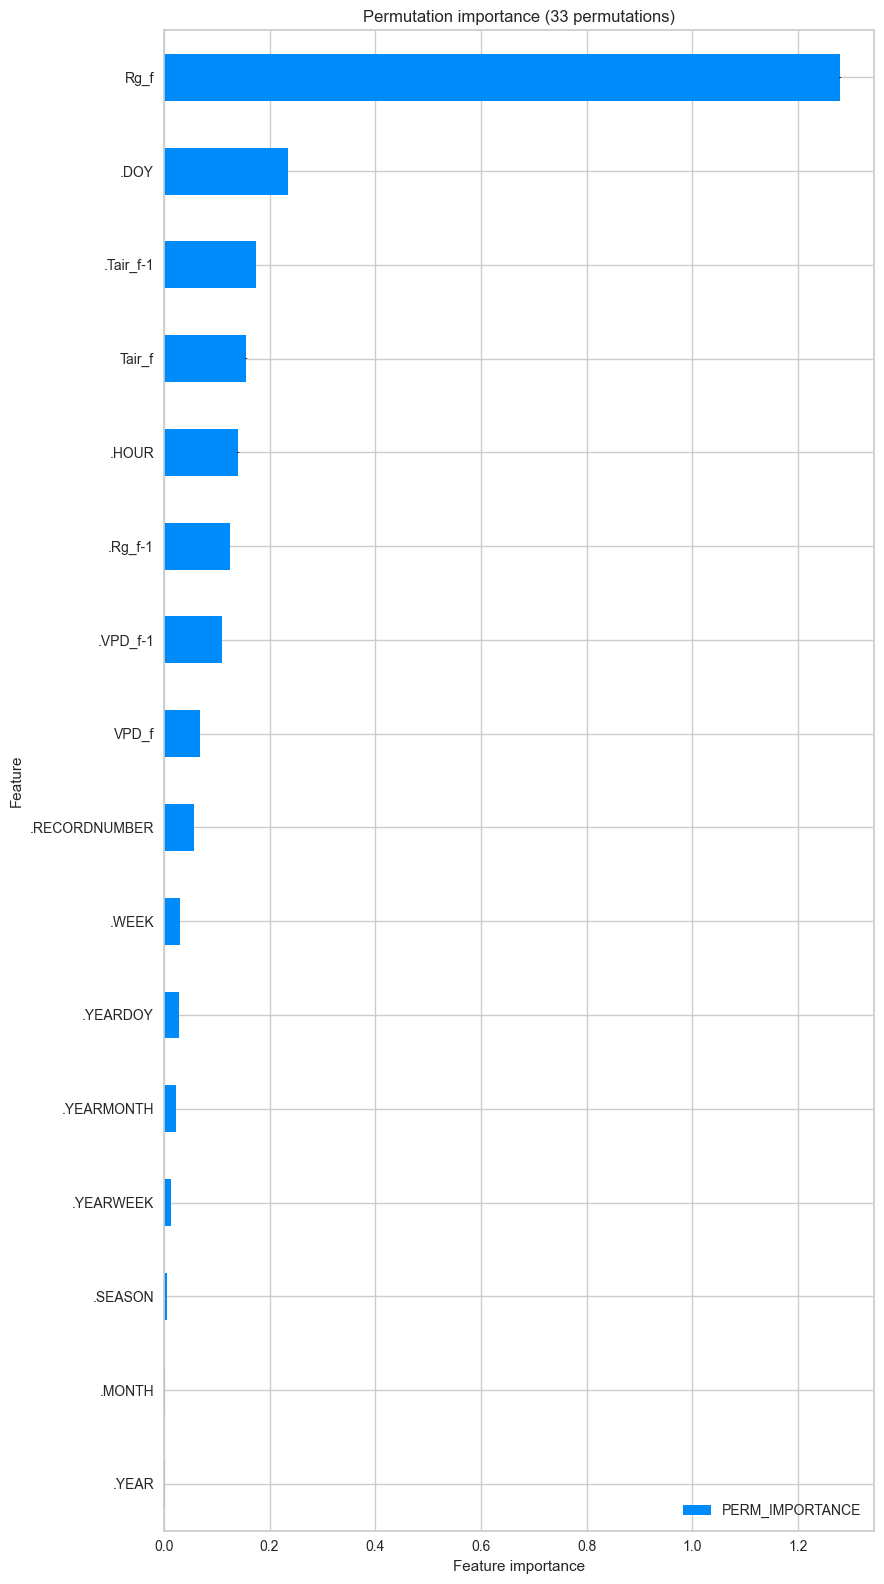

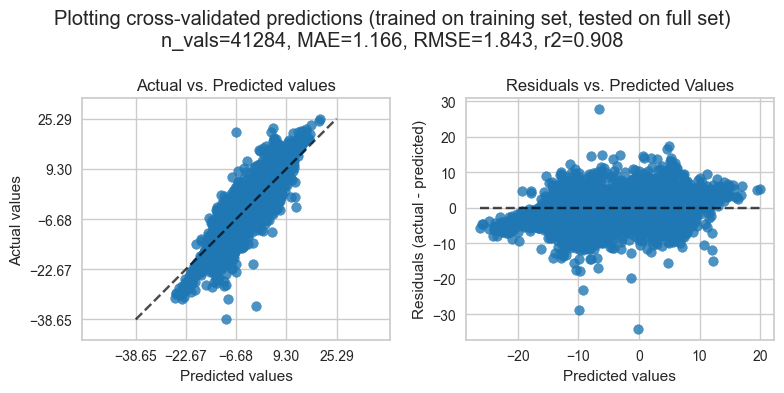


Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)


In [14]:
rfts.fillgaps(showplot_scores=True, showplot_importance=True)

In [15]:
rfts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (134011 values, NEE_CUT_REF_orig_gfRF where flag=1) in comparison to observed targets (41284 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  134012 (cross-check from flag: 134012)
- target column (gap-filled):  NEE_CUT_REF_orig_gfRF  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED
  > flag 0 ... observed targets (41284 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (134011 values)
  > flag 2 ... targets gap-filled with fallback (1 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', '.DOY', '.Tair_f-1', 'Tair_f', '.HOUR', '.Rg_f-1', '.VPD_f-1', 'VPD_f', '.RECORDNUMBER', '

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [16]:
rfts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.279320,0.008230
.DOY,0.234547,0.002299
.Tair_f-1,0.174020,0.001440
Tair_f,0.156050,0.001598
.HOUR,0.139510,0.001838
.Rg_f-1,0.126027,0.001113
.VPD_f-1,0.110334,0.000831
VPD_f,0.068556,0.000696
.RECORDNUMBER,0.057582,0.000501
.WEEK,0.030902,0.000302


In [17]:
rfts.feature_importances_reduction_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.144854,0.015330
.DOY,0.155979,0.004819
.Tair_f-1,0.104334,0.002278
Tair_f,0.091687,0.002930
.HOUR,0.069084,0.002786
.Rg_f-1,0.060504,0.001889
.VPD_f-1,0.053963,0.001570
VPD_f,0.023511,0.001049
.RECORDNUMBER,0.019326,0.000754
.WEEK,0.010755,0.000521


In [18]:
rfts.feature_importances_traintest_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.165858,0.015552
.DOY,0.159883,0.004824
.Tair_f-1,0.104726,0.002509
Tair_f,0.095338,0.002972
.HOUR,0.071144,0.002633
.Rg_f-1,0.061706,0.001785
.VPD_f-1,0.056958,0.001721
VPD_f,0.026315,0.001135
.RECORDNUMBER,0.020721,0.000810
.WEEK,0.011692,0.000752


In [19]:
rfts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,1.019101,1.019101,1.019101,1.019101
2013-01-01 00:45:00,0.951916,NaN,0.951916,1.0,0.951916,1.019101,1.971017,0.951916
2013-01-01 01:15:00,0.957388,NaN,0.957388,1.0,0.957388,0.754690,2.928405,0.957388
2013-01-01 01:45:00,0.960007,0.537565,NaN,0.0,0.537565,0.754690,3.465969,0.960007
2013-01-01 02:15:00,-0.201195,NaN,-0.201195,1.0,-0.201195,0.275713,3.264774,-0.201195
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.912961,NaN,2.912961,1.0,2.912961,3.457961,-61087.751933,2.912961
2022-12-31 22:15:00,3.139203,3.517950,NaN,0.0,3.517950,2.950116,-61084.233983,3.139203
2022-12-31 22:45:00,2.261113,NaN,2.261113,1.0,2.261113,2.950116,-61081.972870,2.261113


In [20]:
rfts.model_

RandomForestRegressor(n_estimators=99, n_jobs=-1, random_state=42)

In [21]:
rfts.accepted_features_

['Rg_f',
 '.DOY',
 '.Tair_f-1',
 'Tair_f',
 '.HOUR',
 '.Rg_f-1',
 '.VPD_f-1',
 'VPD_f',
 '.RECORDNUMBER',
 '.WEEK',
 '.YEARDOY',
 '.YEARMONTH',
 '.YEARWEEK',
 '.SEASON',
 '.MONTH',
 '.YEAR']

In [22]:
rfts.rejected_features_

['.RANDOM']

In [23]:
rfts.scores_

{'mae': 1.165985771849993,
 'medae': 0.7275558936464643,
 'mse': 3.3948690492037947,
 'rmse': 1.8425170417675367,
 'mape': 1.8798142466159153,
 'maxe': 34.056812596222215,
 'r2': 0.9083256232394692}

In [24]:
rfts.scores_test_

{'mae': 2.212068215086223,
 'medae': 1.6146710382525256,
 'mse': 9.606877113129329,
 'rmse': 3.099496267642426,
 'mape': 4.947747096579097,
 'maxe': 34.056812596222215,
 'r2': 0.7421109177735367}

In [25]:
rfts.traintest_details_.keys()

dict_keys(['X', 'y', 'timestamp', 'predictions', 'X_names', 'y_name', 'X_train', 'y_train', 'X_test', 'y_test', 'model'])

</br>

## Result

In [26]:
gapfilled = rfts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1.019101
2013-01-01 00:45:00    0.951916
2013-01-01 01:15:00    0.957388
2013-01-01 01:45:00    0.537565
2013-01-01 02:15:00   -0.201195
                         ...   
2022-12-31 21:45:00    2.912961
2022-12-31 22:15:00    3.517950
2022-12-31 22:45:00    2.261113
2022-12-31 23:15:00    3.090046
2022-12-31 23:45:00    4.183224
Freq: 30T, Name: NEE_CUT_REF_orig_gfRF, Length: 175296, dtype: float64

In [27]:
flag = rfts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    2.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30T, Name: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED, Length: 175296, dtype: float64

In [28]:
gapfilling_df = rfts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,1.019101,1.019101,1.019101,1.019101
2013-01-01 00:45:00,0.951916,NaN,0.951916,1.0,0.951916,1.019101,1.971017,0.951916
2013-01-01 01:15:00,0.957388,NaN,0.957388,1.0,0.957388,0.754690,2.928405,0.957388
2013-01-01 01:45:00,0.960007,0.537565,NaN,0.0,0.537565,0.754690,3.465969,0.960007
2013-01-01 02:15:00,-0.201195,NaN,-0.201195,1.0,-0.201195,0.275713,3.264774,-0.201195
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.912961,NaN,2.912961,1.0,2.912961,3.457961,-61087.751933,2.912961
2022-12-31 22:15:00,3.139203,3.517950,NaN,0.0,3.517950,2.950116,-61084.233983,3.139203
2022-12-31 22:45:00,2.261113,NaN,2.261113,1.0,2.261113,2.950116,-61081.972870,2.261113


</br>

## Plot

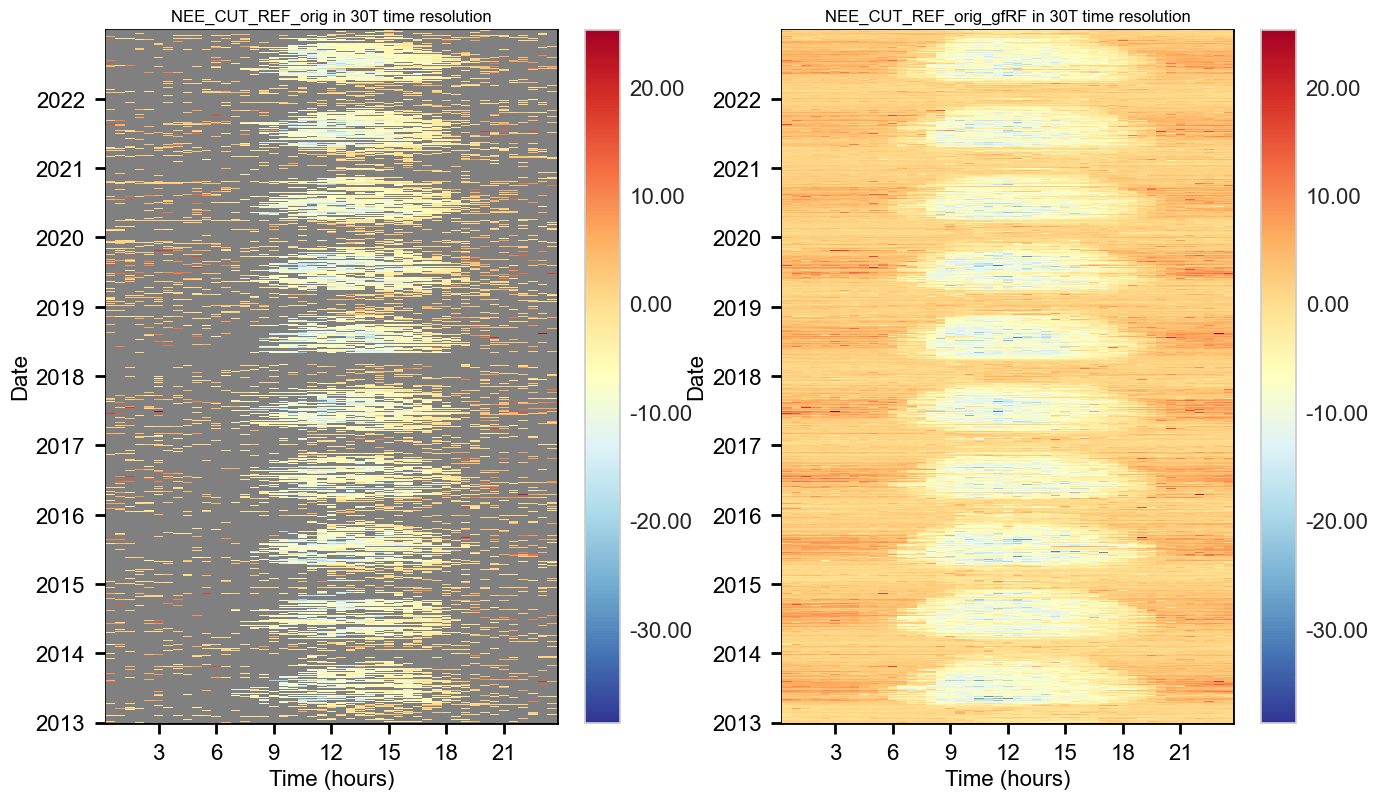

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

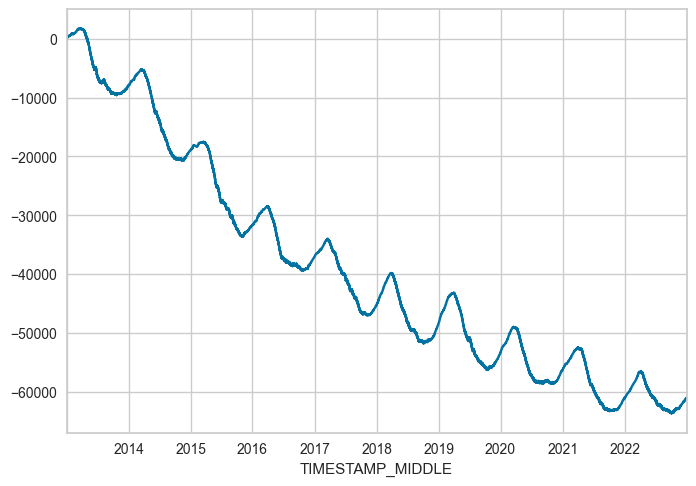

In [30]:
gapfilled.cumsum().plot();

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [31]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-10-25 14:35:18
